In [3]:
import sys
import os

import pandas as pd
import numpy as np
import scipy.stats as stats

import torch
import cv2 as cv
from glob import glob
from PIL import Image
from matplotlib import pyplot as plt

In [4]:
block_id = 'block1_1'
image_dir = f"/home/jiangp/Documents/ann/data/{block_id}/"
image_file_paths = glob(f"{image_dir}/*/*")
image_file_paths

['/home/jiangp/Documents/ann/data/block1_1/n0/image0271_nn_mushroom_16__1.jpg',
 '/home/jiangp/Documents/ann/data/block1_1/n0/image0528_noise_im38_smp12__4.jpg',
 '/home/jiangp/Documents/ann/data/block1_1/n0/image0541_tex_im13_smp10__3.jpg',
 '/home/jiangp/Documents/ann/data/block1_1/n0/image0183_nn_mouse_11__2.jpg',
 '/home/jiangp/Documents/ann/data/block1_1/n0/image0075_nn_flower_17.jpg',
 '/home/jiangp/Documents/ann/data/block1_1/n0/image0662_tex_im30_smp12__2.jpg',
 '/home/jiangp/Documents/ann/data/block1_1/n0/image0006_nn_bird_15__1.jpg',
 '/home/jiangp/Documents/ann/data/block1_1/n0/image0031_nn_cat_10.jpg',
 '/home/jiangp/Documents/ann/data/block1_1/n0/image0261_nn_mushroom_14__3.jpg',
 '/home/jiangp/Documents/ann/data/block1_1/n0/image0430_noise_im18_smp11__3.jpg',
 '/home/jiangp/Documents/ann/data/block1_1/n0/image0645_tex_im23_smp10.jpg',
 '/home/jiangp/Documents/ann/data/block1_1/n0/image0205_nn_mouse_21.jpg',
 '/home/jiangp/Documents/ann/data/block1_1/n0/image0674_tex_im38_

get low/high frequency pass filter

In [93]:
# The delimiter is not the same between different platforms
if sys.platform == "win32":
    delimiter = "\\"
else:
    delimiter = "/"

for path in image_file_paths:
    img = cv.imread(f'{path}', cv.IMREAD_GRAYSCALE)
    assert img is not None, "file could not be read, check with os.path.exists()"
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)

    rows, cols = img.shape
    crow, ccol = rows//2 , cols//2

    # low pass filter
    f_lpf = fshift
    f_lpf[:crow-40, :] = 0
    f_lpf[crow+41:, :] = 0
    f_lpf[crow-40:crow+41:, :ccol-40] = 0
    f_lpf[crow-40:crow+41:, ccol+41:] = 0
    f_ilpf = np.fft.ifftshift(f_lpf)
    img_lpf = np.fft.ifft2(f_ilpf)
    img_lpf = np.real(img_lpf)

    image_dir, image_name = path.split(delimiter)[-2:]

    cv.imwrite(f'/home/jiangp/Documents/ann/data/block1_1/lpf/{image_name}', img_lpf) 

In [94]:
# The delimiter is not the same between different platforms
if sys.platform == "win32":
    delimiter = "\\"
else:
    delimiter = "/"

for path in image_file_paths:
    img = cv.imread(f'{path}', cv.IMREAD_GRAYSCALE)
    assert img is not None, "file could not be read, check with os.path.exists()"
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)

    rows, cols = img.shape
    crow, ccol = rows//2 , cols//2

    # high pass filter
    f_hpf = fshift
    f_hpf[crow-40:crow+41, ccol-40:ccol+41] = 0
    f_ihpf = np.fft.ifftshift(f_hpf)
    img_hpf = np.fft.ifft2(f_ihpf)
    img_hpf = np.real(img_hpf)

    image_dir, image_name = path.split(delimiter)[-2:]

    cv.imwrite(f'/home/jiangp/Documents/ann/data/block1_1/hpf/{image_name}', img_hpf) 

plot power spectrum of image

In [ ]:
# # get type_label for stim_list

# stim_list = [os.path.split(filename)[1] for filename in image_file_paths]

# img_meta = pd.read_csv(f'/data/decipher_variability/variability_phase4/visual_stimuli/production/images_{block_id}.csv')
# stim_list_sorted = [fn.split('.')[0]+".jpg" for fn in img_meta['filename']]

# stim_perm_index = []
# for stim in stim_list:
#     stim_perm_index.append(stim_list_sorted.index(stim))

# img_meta['stim_type'][stim_perm_index]

In [5]:
# calculate power spectrum
# refer to link https://bertvandenbroucke.netlify.app/2019/05/24/computing-a-power-spectrum-in-python/

folder_path = os.path.split(image_file_paths[0])[0]
img_meta = pd.read_csv(f'/data/decipher_variability/variability_phase4/visual_stimuli/production/images_{block_id}.csv')
stim_list_sorted = [fn.split('.')[0]+".jpg" for fn in img_meta['filename']]

power_spectrum_images = []

for path in stim_list_sorted:

    img = cv.imread(folder_path+'/'+path, cv.IMREAD_GRAYSCALE)

    npix = img.shape[0]

    fourier_image = np.fft.fftn(img)
    fourier_amplitudes = np.abs(fourier_image)**2

    kfreq = np.fft.fftfreq(npix) * npix
    kfreq2D = np.meshgrid(kfreq, kfreq)
    knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)

    knrm = knrm.flatten()
    fourier_amplitudes = fourier_amplitudes.flatten()

    kbins = np.arange(0.5, npix//2+1, 1.)
    kvals = 0.5 * (kbins[1:] + kbins[:-1])
    Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                        statistic = "mean",
                                        bins = kbins)
    # Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)

    power_spectrum_images.append(Abins)

power_spectrum_images = np.array(power_spectrum_images)
print(power_spectrum_images.shape)

(773, 112)


Text(0.5, 1.0, 'Power spectrum of natural image, texure and noise')

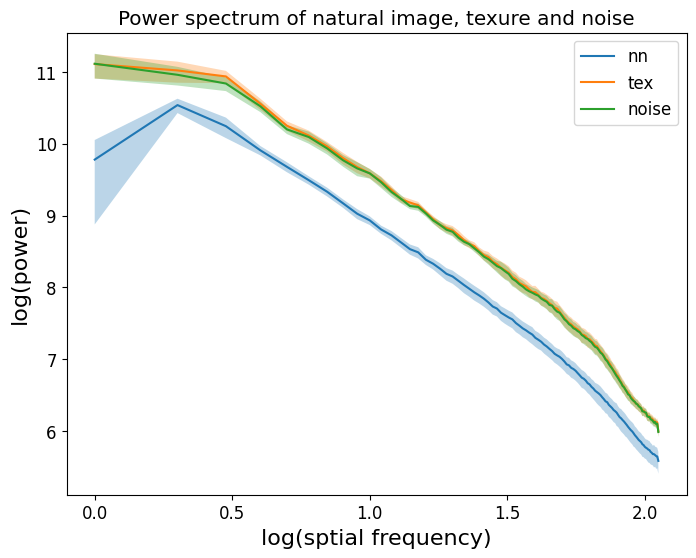

In [13]:
stim_types = ['nn', 'tex', 'noise']
color_list = ['#1f77b4', '#ff7f0e', '#2ca02c']
plt.rcParams['font.size'] = '12'

plt.figure(figsize=(8, 6))
for i, type in enumerate(stim_types):
    power_spectrum = power_spectrum_images[img_meta['stim_type']==type]
    # x = np.arange(power_spectrum.shape[1])
    mean = power_spectrum.mean(0)
    std = power_spectrum.std(0)
    plt.plot(np.log10(kvals), np.log10(mean), c=color_list[i], label=type)
    plt.fill_between(np.log10(kvals), np.log10(mean+0.4*std), np.log10(mean-0.4*std), facecolor=color_list[i], alpha=0.3)

plt.legend()
plt.xlabel("log(sptial frequency)", fontsize=16)
plt.ylabel("log(power)", fontsize=16)
plt.title('Power spectrum of natural image, texure and noise')

--------------just try-----------------

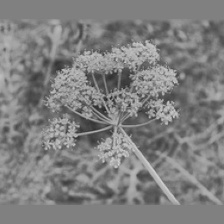

(224, 224)

In [6]:
im = Image.open('/home/jiangp/Documents/ann/data/block1_1/n0/image0110_nn_flower_5.jpg')
im.show()
imarray = np.array(im)
imarray.shape

([], [])

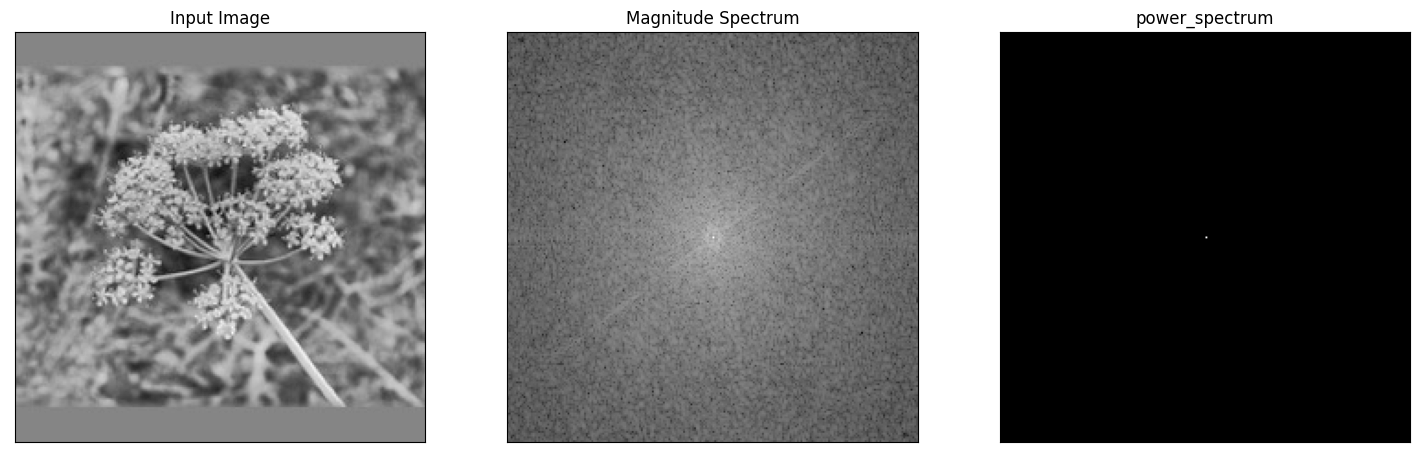

In [11]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
img = cv.imread('/home/jiangp/Documents/ann/data/block1_1/n0/image0110_nn_flower_5.jpg', cv.IMREAD_GRAYSCALE)
assert img is not None, "file could not be read, check with os.path.exists()"
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
magnitude_spectrum = np.log(np.abs(fshift))
# magnitude_spectrum = 20*np.log(np.abs(fshift))
# Calculate the power spectrum
power_spectrum = np.abs(fshift)**2
plt.figure(figsize=(18, 6))
plt.subplot(131)
plt.imshow(img, cmap = 'gray')
plt.title('Input Image')
plt.xticks([])
plt.yticks([])
plt.subplot(132)
plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum')
plt.xticks([])
plt.yticks([])
plt.subplot(133)
plt.imshow(power_spectrum, cmap = 'gray')
plt.title('power_spectrum')
plt.xticks([])
plt.yticks([])

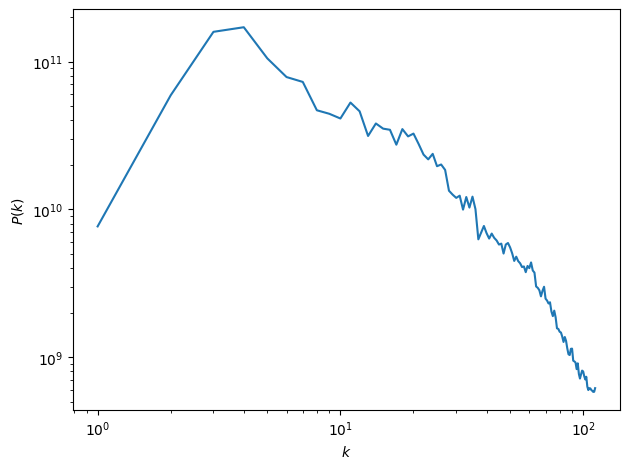

In [44]:
import scipy.stats as stats
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

img = cv.imread('/home/jiangp/Documents/ann/data/block1_1/n0/image0110_nn_flower_5.jpg', cv.IMREAD_GRAYSCALE)

npix = img.shape[0]

fourier_image = np.fft.fftn(img)
fourier_amplitudes = np.abs(fourier_image)**2

kfreq = np.fft.fftfreq(npix) * npix
# kfreq = np.fft.fftfreq(npix)
kfreq2D = np.meshgrid(kfreq, kfreq)
knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)

knrm = knrm.flatten()
fourier_amplitudes = fourier_amplitudes.flatten()

kbins = np.arange(0.5, npix//2+1, 1.)
kvals = 0.5 * (kbins[1:] + kbins[:-1])
Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                     statistic = "mean",
                                     bins = kbins)
Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)

plt.loglog(kvals, Abins)
# plt.plot(kvals, Abins)
plt.xlabel("$k$")
plt.ylabel("$P(k)$")
plt.tight_layout()
# plt.savefig("cloud_power_spectrum.png", dpi = 300, bbox_inches = "tight")

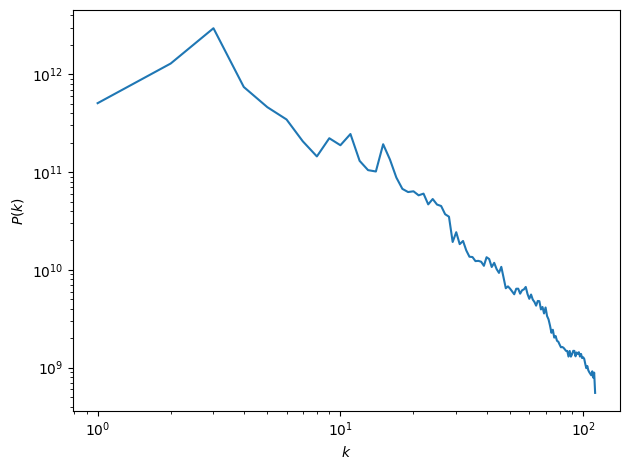

In [45]:

import scipy.stats as stats
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

img = cv.imread('/home/jiangp/Documents/ann/data/block1_1/n0/image0528_noise_im38_smp12__4.jpg', cv.IMREAD_GRAYSCALE)

npix = img.shape[0]

fourier_image = np.fft.fftn(img)
fourier_amplitudes = np.abs(fourier_image)**2

kfreq = np.fft.fftfreq(npix) * npix
# kfreq = np.fft.fftfreq(npix)
kfreq2D = np.meshgrid(kfreq, kfreq)
knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)

knrm = knrm.flatten()
fourier_amplitudes = fourier_amplitudes.flatten()

kbins = np.arange(0.5, npix//2+1, 1.)
kvals = 0.5 * (kbins[1:] + kbins[:-1])
Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                     statistic = "mean",
                                     bins = kbins)
Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)

plt.loglog(kvals, Abins)
# plt.plot(kvals, Abins)
plt.xlabel("$k$")
plt.ylabel("$P(k)$")
plt.tight_layout()
# plt.savefig("cloud_power_spectrum.png", dpi = 300, bbox_inches = "tight")

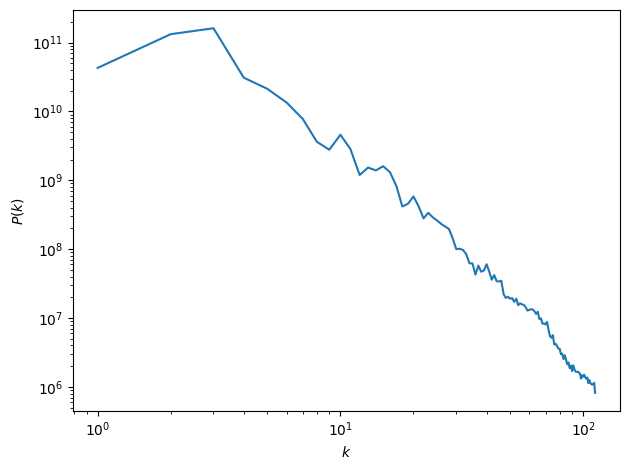

In [41]:
import scipy.stats as stats
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

img = cv.imread('/home/jiangp/Documents/ann/data/block1_1/n0/image0677_tex_im38_smp12__4.jpg', cv.IMREAD_GRAYSCALE)

npix = img.shape[0]

fourier_image = np.fft.fftn(img)
fourier_amplitudes = np.abs(fourier_image)**2

kfreq = np.fft.fftfreq(npix) * npix
# kfreq = np.fft.fftfreq(npix)
kfreq2D = np.meshgrid(kfreq, kfreq)
knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)

knrm = knrm.flatten()
fourier_amplitudes = fourier_amplitudes.flatten()

kbins = np.arange(0.5, npix//2+1, 1.)
kvals = 0.5 * (kbins[1:] + kbins[:-1])
Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                     statistic = "mean",
                                     bins = kbins)
# Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)

plt.loglog(kvals, Abins)
# plt.plot(kvals, Abins)
plt.xlabel("$k$")
plt.ylabel("$P(k)$")
plt.tight_layout()
# plt.savefig("cloud_power_spectrum.png", dpi = 300, bbox_inches = "tight")

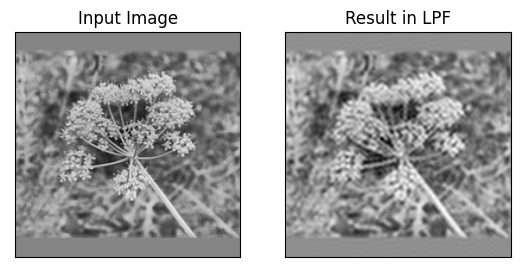

In [89]:
rows, cols = img.shape
crow, ccol = rows//2 , cols//2

f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)

# low pass filter
f_lpf = fshift
f_lpf[:crow-40, :] = 0
f_lpf[crow+41:, :] = 0
f_lpf[crow-40:crow+41:, :ccol-40] = 0
f_lpf[crow-40:crow+41:, ccol+41:] = 0
f_ilpf = np.fft.ifftshift(f_lpf)
img_lpf = np.fft.ifft2(f_ilpf)
img_lpf = np.real(img_lpf)

cv2.imwrite('/home/jiangp/Documents/ann/data/block1_1/lpf/image0110_nn_flower_5.jpg', img_lpf) 

plt.subplot(121)
plt.imshow(img, cmap = 'gray')
plt.title('Input Image')
plt.xticks([])
plt.yticks([])
plt.subplot(122)
plt.imshow(img_lpf, cmap = 'gray')
plt.title('Result in LPF')
plt.xticks([])
plt.yticks([])
plt.show()

([], [])

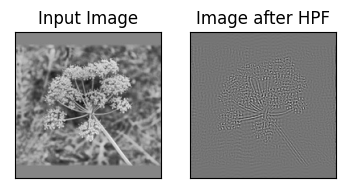

In [90]:
rows, cols = img.shape
crow, ccol = rows//2 , cols//2

f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)

# high pass filter
f_hpf = fshift
f_hpf[crow-40:crow+41, ccol-40:ccol+41] = 0
f_ihpf = np.fft.ifftshift(f_hpf)
img_hpf = np.fft.ifft2(f_ihpf)
img_hpf = np.real(img_hpf)

	
cv2.imwrite('/home/jiangp/Documents/ann/data/block1_1/hpf/image0110_nn_flower_5.jpg', img_hpf) 

plt.subplot(131)
plt.imshow(img, cmap = 'gray')
plt.title('Input Image')
plt.xticks([])
plt.yticks([])
plt.subplot(132)
plt.imshow(img_hpf, cmap = 'gray')
plt.title('Image after HPF')
plt.xticks([])
plt.yticks([])
